## Intro

This notebook runs independant pytorch MLPs on the winequality dataset in a regression scenario

In [1]:
# # # local
project_directory = "../"


# # # # colab
# from google.colab import drive
# drive.mount('/content/drive')
# project_directory = "/content/drive/MyDrive/colab_working_directory/diversity-enforced-ensembles/"
# !pip install cached-property

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

# allow import of decompose locally
import sys
sys.path.append(project_directory + 'src/')


from decompose import SquaredLoss
import bvdlib

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
save_path = project_directory + "experiments/results/Torch_Independant_MLP_over_n_members_winequality_regression.pkl"

## Pre-Process Data

In [4]:
# get data

data_path = Path(project_directory + 'data/Wine_Quality/data.csv')
winequal_data = pd.read_csv(data_path)
winequal_data

x = winequal_data.iloc[:, 1:-2].to_numpy()
y = winequal_data.iloc[:, -2:-1].to_numpy().squeeze()

print("x shape", x.shape)
print("y shape", y.shape)

x shape (6497, 11)
y shape (6497,)


In [5]:
#define settings

n_trials = 100
data_percentage_training = int(0.8 * len(y))
num_training =  int(0.8 * data_percentage_training) # percent of data for each trial from training
trial_space = np.arange(1,21) # Test estimators from 1 to 20

In [6]:
# seed experiment
experiment_seed = 0
np.random.seed(experiment_seed)
# split and preprocess data,
rng = np.random.default_rng()
shuffled_indices = rng.permutation(len(y))

train_indices = shuffled_indices[:data_percentage_training]
test_indices = shuffled_indices[data_percentage_training:]
train_data = x[train_indices, :]
train_labels = y[train_indices]
test_data = x[test_indices, :]
test_labels = y[test_indices]

## Run Experiments

### Torch Independent MLPS

In [7]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim, generator, hidden_size=16):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_dim)

        nn.init.xavier_uniform_(self.fc1.weight, generator=generator)
        nn.init.xavier_uniform_(self.fc2.weight, generator=generator)
        nn.init.xavier_uniform_(self.fc3.weight, generator=generator)

    def forward(self, x):

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class trial_dataset(torch.utils.data.Dataset):
  def __init__(self, x, y, device):
    self.x = torch.tensor(x).type(torch.float).to(device)
    self.y = torch.tensor(y).type(torch.float).to(device)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [8]:
model_function = SimpleMLP
decomp_fn = SquaredLoss
loss_fn = torch.nn.MSELoss()
torch_generator = torch.manual_seed(experiment_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epoch_num = 2

# define a trial
def trial_run(trial):

    trial_x, trial_y = trial.get_data
    trialset = trial_dataset(trial_x, trial_y, device)
    n_estim = trial.get_singular_parameter()

    input_dim = len(trial_x[0])
    output_dim = 1

    dataloaders = []
    models = []
    for estimator_id in range(n_estim):
        dataloaders.append(torch.utils.data.DataLoader(trialset, batch_size = 8, shuffle=True, generator=torch_generator))
        model = model_function(input_dim, output_dim, torch_generator)
        model.to(device)
        models.append(model)


    for i, model in enumerate(models):
        optim=torch.optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(epoch_num):
            for step, (x, y) in enumerate(dataloaders[i]):
                optim.zero_grad()
                pred = model(x).squeeze()
                loss = loss_fn(pred, y)
                loss.backward()
                optim.step()



    trial_results_array = np.zeros((n_estim, len(test_data)))

    train_losses = []
    with torch.no_grad():
        for i, model in enumerate(models):
            train_preds = model(torch.tensor(trial_x).type(torch.float).to(device)).squeeze()
            train_losses.append(loss_fn(train_preds.to(device), torch.tensor(trial_y).type(torch.float).to(device)).cpu())
            member_preds = model(torch.tensor(test_data).type(torch.float).to(device)).squeeze()
            trial_results_array[i, :] = member_preds.cpu().squeeze()

    return np.array(trial_results_array), np.mean(np.array(train_losses))
    

torch_mlp_study = bvdlib.Study(trial_space, train_data, train_labels, test_data, test_labels, 
                     num_training, n_trials, decomp_fn)
torch_mlp_results = torch_mlp_study.run_trials(trial_run)

# save results
torch_mlp_results.save_results(save_path)

0
1


KeyboardInterrupt: 

<Axes: xlabel='n_estimators'>

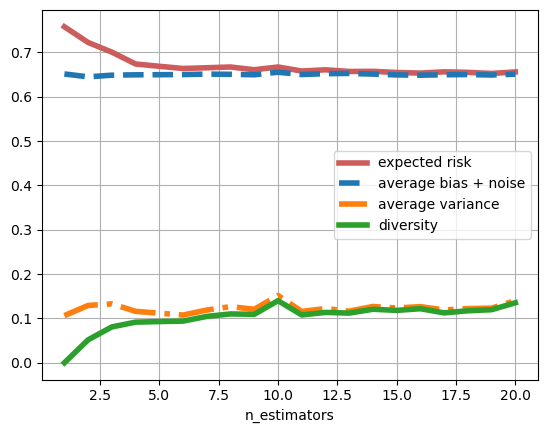

In [ ]:
from decompose.plotting_utils import plot_bvd
plot_bvd(torch_mlp_results)